# Tutorial: Remote Quantum Operations

## Introduction

This tutorial assumes some familiarity with quantum circuits and QISkit. We will walk through a variety of ways one can use particular quantum states (also known as "resource states") as a mediator for quantum operations. The resource state we will be focusing on is the so-called Einstein-Podolsky-Rosen (or EPR) state. We will be using a small library that implements some EPR-mediated quantum operations.

Let's start by installing the `remoteOps` package from this [GitHub repository](http://github.com). Simply clone and install with pip:
```
git clone http://github.com && pip install ./remoteOps
```

Removing the small package from your system is equally easy:
```
pip uninstall remoteOps
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import
import qiskit.circuit as qc
from qiskit.compiler import transpile
import remoteOps
import numpy as np

## Background
Quantum information processing (QIP) tends to rely on operations on multiple qubits in order to be useful. This is entirely analogous to the fact that unary operators in <i>classical</i> information processing themselves are not terribly useful without binary ones as well.

Classically, a binary gate can only be performed between distant bits can only happen if one of the operands is transmitted towards the other. In QIP by contrast, a fascinating result is that neither (quantum) operand needs be transmitted, as long as each party in possession of an operand also possesses some (entangled) resource state. That state can then be used, along with the transmission of <i>classical</i> information, for a two-qubit operator to be effected between distant qubits even when neither qubit is in fact being transmitted through a channel. In this tutorial, we will default to the following resource state:
<center>
$\left|\Phi_{+}\right>=\frac{\left|00\right>+\left|11\right>}{\sqrt{2}}$
</center>

For the purposes of simulation (e.g. via the Aer simulator, say) we provide a simple instruction to prepare this state:

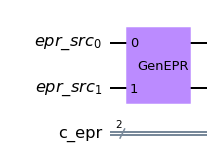

In [3]:
# Define a register to hold the state.
example_qreg = qc.QuantumRegister(2, "epr_src")
# Define an empty quantum circuit
example_circuit = qc.QuantumCircuit(example_qreg)
# Now add an EPR generation instruction
remoteOps.addInstr(example_circuit, 'GenEPR', epr_qreg=example_qreg)

example_circuit.draw(output='mpl')

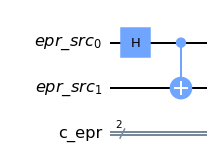

In [4]:
# We can also decompose the instruction into more basic operations
remoteOps.decompose(example_circuit)
example_circuit.draw(output='mpl')

## Using EPR states: Remote CX (simple case)
The controlled-NOT (a.k.a. CX or CNOT) gate is a common two-qubit gate that is a quantum-coherent analogue of the classical exclusive-OR (a.k.a. XOR).

We'll now start with a simple and arbitrary circuit and replace the CX gate in it with an EPR-mediated one.

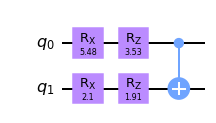

In [5]:
# Generate random gate parameters.
a,b,c,d = np.random.rand(4)*2*np.pi

# Create a circuit
ex_cx_1 = qc.QuantumCircuit(2)
ex_cx_1.rx(a,0)
ex_cx_1.rx(b,1)
ex_cx_1.rz(c,0)
ex_cx_1.rz(d,1)
ex_cx_1.cnot(0,1) # We will replace this with an EPR operation.

# Print
ex_cx_1.draw(output='mpl')

/Volumes/OpenStorage/micromamba/envs/main38/lib/python3.8/site-packages/qiskit/visualization/matplotlib.py:317: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  self._get_layer_widths()


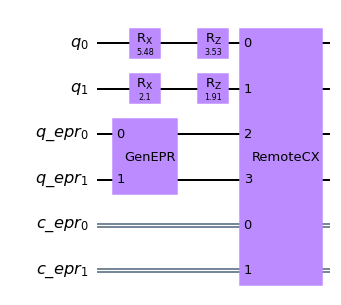

In [6]:
# Now let's compose the same circuit with an EPR-mediated CX
qreg_cx_2 = qc.QuantumRegister(2, 'q')
ex_cx_2 = qc.QuantumCircuit(qreg_cx_2)
ex_cx_2.rx(a,0)
ex_cx_2.rx(b,1)
ex_cx_2.rz(c,0)
ex_cx_2.rz(d,1)
remoteOps.addInstr(ex_cx_2, 'RemoteCX', qreg_cx_2[0], qreg_cx_2[1],[])

# Print
ex_cx_2.draw(output='mpl')

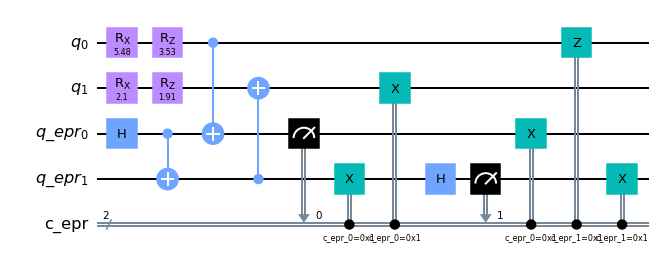

In [7]:
# In decomposed form
remoteOps.decompose(ex_cx_2)
ex_cx_2.draw(output='mpl')

<font color=red>Note that in its decomposed form, operands q0 and q1 never "talk to" each other directly. Instead, they interact via the EPR state stored in register "q_epr", and through the <i>classical</i> register "c_epr".</font>

## Using EPR states: A slightly more sophisticated case
Here we'll show a <b><i>slightly</i></b> more sophisticated example than an arbitrary circuit with a CX. We'll define two registers ('reg_1' and 'reg_2'). We'll do bitwise addition of qubits within 'reg_1', using 'reg_2' as the output register.

In the first instance, we'll simply write down a simple circuit that leaves the most-significant-bit (MSB) of the result in 'reg_2' qubit 0, and the LSB in 'reg_2' qubit 1.

As a case study, we will suppose that the two registers ('reg_1' and 'reg_2') can only undergo two-qubit operations via an EPR state. That is, they may be physically distant.

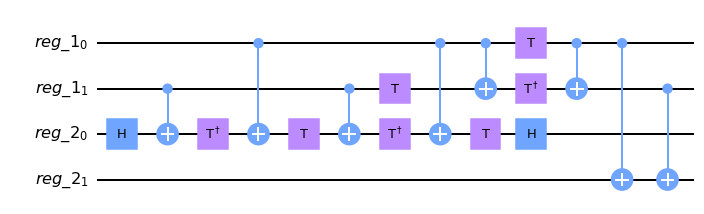

In [37]:
# Define registers
qreg_1 = qc.QuantumRegister(2, "reg_1")
qreg_2 = qc.QuantumRegister(2, "reg_2")
ex_adder = qc.QuantumCircuit(qreg_1, qreg_2)

# Do bitwise addition.
ex_adder.ccx(qreg_1[0], qreg_1[1], qreg_2[0])
ex_adder.cx(qreg_1[0], qreg_2[1])
ex_adder.cx(qreg_1[1], qreg_2[1])

# Substitute Toffoli with more basic gates:
ex_adder = transpile(ex_adder, basis_gates=['cx','t','tdg','h'])

ex_adder.draw(output='mpl')

/Volumes/OpenStorage/micromamba/envs/main38/lib/python3.8/site-packages/qiskit/visualization/matplotlib.py:317: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  self._get_layer_widths()


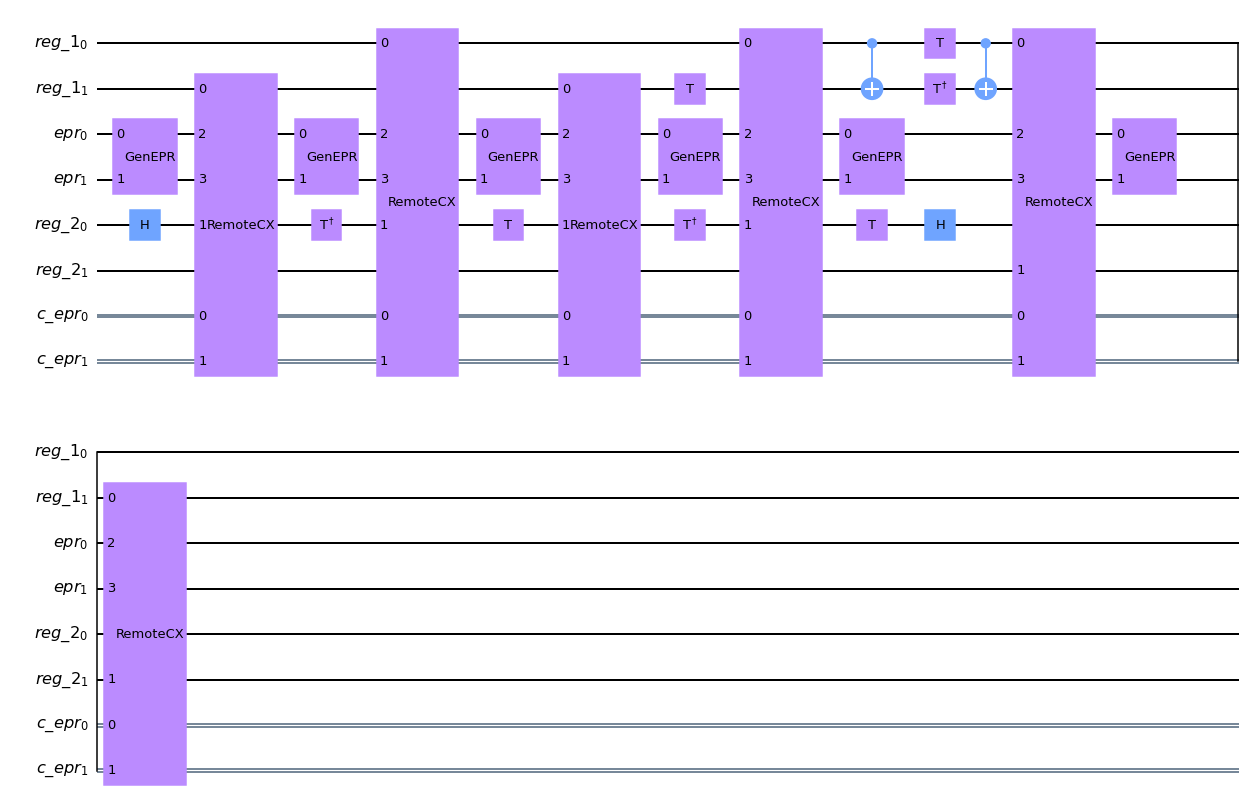

In [38]:
# Suppose any CX operation between Registers 1 and 2 can only happen via EPR-mediation.

# Let's insert an "epr" register to our circuit
# Note, this is not *strictly* necessary. As seen above, a placeholder
# register is automatically inserted if we hadn't provided one.
qreg_epr = qc.QuantumRegister(2, 'epr')
ex_adder_epr = qc.QuantumCircuit(qreg_1, qreg_epr, qreg_2)

# Port over the existing circuit
ex_adder_epr.data = ex_adder.data

# Now call the autosubstitute routine, instructing it to
# replace any operations that cross registers 1 and 2.
remoteOps.autosubstitute(ex_adder_epr, reglist=[qreg_1,qreg_2], epr_qreg=qreg_epr)

ex_adder_epr.draw(output='mpl')

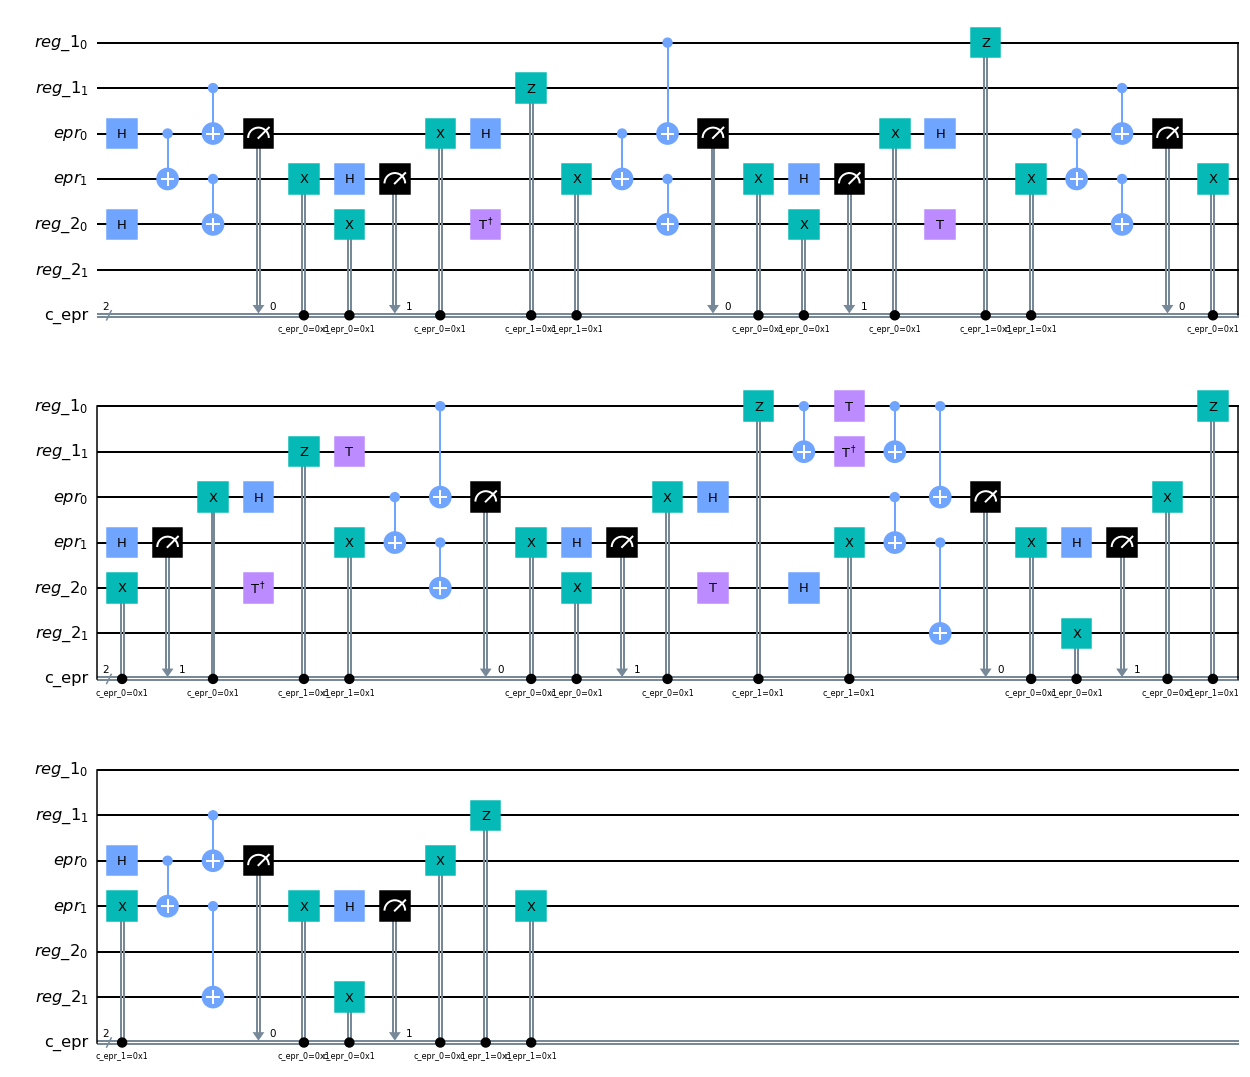

In [39]:
# Finally, we can decompose these if we want (though it won't be pretty to look at!)
remoteOps.decompose(ex_adder_epr)
ex_adder_epr.draw(output='mpl')

<font color=red>Once again, notice that nothing in the EPR-mediated circuit, all qubits in reg_1 only "talks to" the EPR register. The same is true for the reg_2 register. No qubit in reg_1 "talks to" any qubit in reg_2, and vice versa.</font>

### Better efficiency through re-ordering
Now in all the examples shown so far, we've used the EPR resource state purely for mediating CX operations.

In this sub-section, we'll stick with the adder example, but show that sometimes we can simply front-load the broadcasting or moving of qubits which can sometimes yield more efficient circuits.

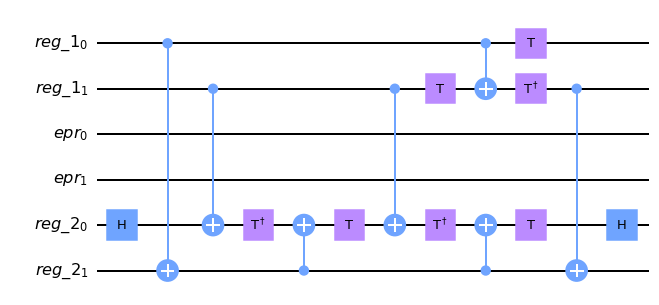

In [45]:
# As before, we'll define an empty circuit first.
ex_adder_tele = qc.QuantumCircuit(qreg_1, qreg_epr, qreg_2)

# The penultimate CX in our original circuit can occur first:
ex_adder_tele.cx(qreg_1[0], qreg_2[1])

# Now, as long as there are no hadamards in either reg_1[0] or reg_2[1],
# we essentially have the first qubit of reg_1 "broadcasted" across registers.
# Now we can do the Toffoli, taking care to avoid inter-register operations.
ex_adder_tele.h(qreg_2[0])
ex_adder_tele.cx(qreg_1[1], qreg_2[0])
ex_adder_tele.tdg(qreg_2[0])
ex_adder_tele.cx(qreg_2[1], qreg_2[0])
ex_adder_tele.t(qreg_2[0])
ex_adder_tele.cx(qreg_1[1], qreg_2[0])
ex_adder_tele.t(qreg_1[1])
ex_adder_tele.tdg(qreg_2[0])
ex_adder_tele.cx(qreg_2[1], qreg_2[0])
ex_adder_tele.cx(qreg_1[0], qreg_1[1])
ex_adder_tele.t(qreg_1[0])
ex_adder_tele.tdg(qreg_1[1])
ex_adder_tele.t(qreg_2[0])
ex_adder_tele.h(qreg_2[0])

# LSB xor.
ex_adder_tele.cx(qreg_1[1], qreg_2[1])

ex_adder_tele = transpile(ex_adder_tele, basis_gates=['cx','t','tdg','h'])

ex_adder_tele.draw(output='mpl')

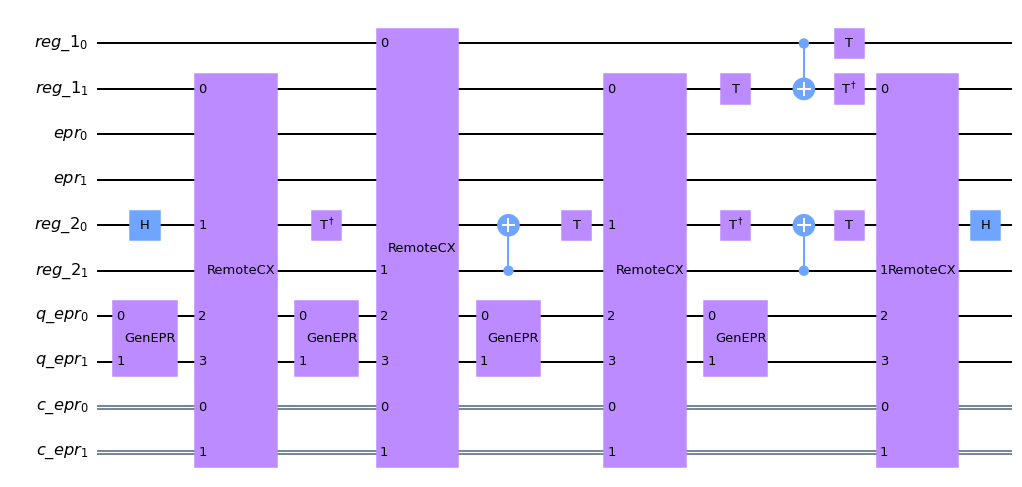

In [46]:
# And as before, autosubstitute with EPR-mediated operations....
remoteOps.autosubstitute(ex_adder_tele, reglist=[qreg_1,qreg_2])

ex_adder_tele.draw(output='mpl')

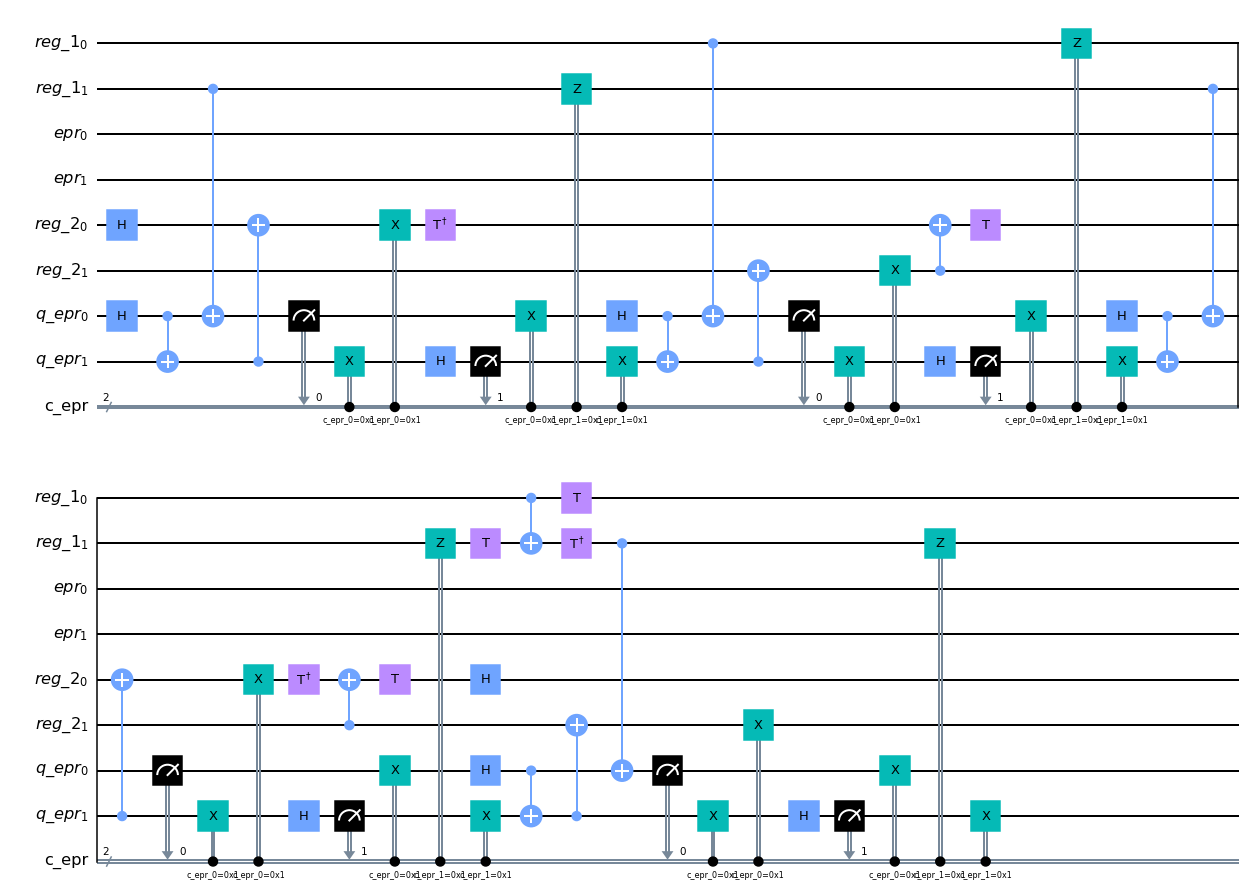

In [47]:
# ... and decompose into fundamental gates.
remoteOps.decompose(ex_adder_tele)

ex_adder_tele.draw(output="mpl")

<font color=red>Note that with a simple re-order of gates, we can broadcast or change the register residency of a qubit, and sometimes end up having to do less work. This can be especially import, for example, when registers 1 and 2 are in fact distant and EPR-mediated operations expensive or time-consuming</font>

So far we have focused primarily on the use of EPR-mediated CX gates. The small library you just installed also contains pre-built substitutions for other common two-qubit operations like CRZ, RZZ, and even straight-up teleportation! Feel free to explore...